# Import

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime
from functions import remove_high_corr, scale_variables, best_params_grid,\
    calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label,get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split,\
    cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,\
    make_scorer, balanced_accuracy_score, f1_score, matthews_corrcoef

# Load data

In [2]:
data = pd.read_csv('/home/gustavo/github/mestrado/reworks/models/oral_vs_non_oral/data/fda_heuristics_preprocessed.csv')
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.16143
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.48830
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.95610
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.12510
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00530


# Separating X and Y matrices, and test and train

In [3]:
Y = data['oral']
# Transforming oral into two categories

Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: oral, dtype: float64

In [4]:
X = data.iloc[:,14:]
X.head()

,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumAmideBonds,FractionCSP3,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,59.048347,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.16143
1,75.032028,3.0,2.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.48830
2,76.027277,4.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.95610
3,77.029920,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.12510
4,78.013936,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00530


In [5]:
np.random.seed(6752)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Scaling datasets

In [6]:
# Train
x_train_scaled = scale_variables(x_train)
# Addcing a constant to represent the intercept term
x_train_scaled = sm.add_constant(x_train_scaled)
x_train_scaled.head()

,const,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumAmideBonds,FractionCSP3,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,1.0,-1.054634,-1.052825,-0.538254,-0.311746,0.382787,-0.630519,-1.175152,-0.495911,-0.905778,-0.769316,-1.003819,-0.682584,-0.748248,-0.221223,-0.676516,-0.303655
1,1.0,0.387005,1.525707,1.634642,1.695765,2.208087,-0.045094,-1.175152,-0.495911,-0.905778,-0.769316,-0.255824,0.588651,-0.748248,-0.221223,-0.096178,-1.062172
2,1.0,0.175480,-0.021412,0.330904,1.026594,-0.529864,-0.833166,0.570987,1.959454,-0.905778,-0.769316,-0.255824,0.588651,-0.748248,-0.221223,-0.386347,0.483537
3,1.0,-0.648440,-0.279265,-0.538254,-0.980916,0.382787,-0.765617,0.570987,0.322544,0.376205,0.019427,1.240167,1.859886,0.181175,-0.221223,-0.676516,0.009914
4,1.0,0.322719,-0.021412,-0.538254,0.803538,0.382787,-0.599342,0.570987,1.140999,-0.264787,0.019427,0.492171,0.588651,0.181175,-0.221223,-0.676516,0.300718


In [7]:
# Test
x_test_scaled = scale_variables(x_test)
x_test_scaled = sm.add_constant(x_test_scaled)
x_test_scaled.head()

,const,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumAmideBonds,FractionCSP3,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,CrippenClogP
0,1.0,0.962464,0.453445,0.326861,0.800876,-0.514960,-0.090808,0.502726,1.092537,-0.301836,-0.015850,0.538884,0.618353,0.181638,-0.2249,-0.626435,1.625168
1,1.0,0.021356,0.453445,0.326861,0.383946,-0.514960,0.858357,-0.645670,-0.515732,-0.301836,-0.767134,0.538884,0.618353,0.181638,-0.2249,-0.361555,-1.245475
2,1.0,-0.448490,-0.216824,-0.049188,-0.866846,1.101536,-1.095807,-0.071472,0.288402,-0.301836,-0.767134,-0.254380,-0.650475,0.181638,-0.2249,-0.361555,0.116326
3,1.0,-0.361528,-0.887094,-0.425237,-0.866846,-0.514960,1.238023,0.502726,-1.319866,1.572449,1.486718,-1.047643,-0.650475,-0.764477,-0.2249,0.962844,0.490950
4,1.0,-1.221623,-0.440247,0.702910,-0.866846,-0.514960,-1.799306,-1.219868,-0.515732,-0.926598,-0.767134,-1.047643,-0.650475,-0.764477,-0.2249,-0.626435,-0.977534


In [8]:
# Dataframe to store final results from every model
final_results = pd.DataFrame(
    columns=[
        "model_name",
        'cv_test_auc',
        'training_mis_rate',
        'test_mis_rate',
        'training_auc',
        'test_auc',
        'balanced_acc_test',
        'mcc_train',
        'mcc_tets'
    ]
)

# Logit

## CV


In [9]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=500),
        'params': {}
    }
}

In [10]:
gs_results_lr, gs_result_lr_full = best_params_grid(x_train_scaled, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 22:45
Finished Grid Search for Logistic Regression: 22:45
Tempo de execução:  0.0 minutos


In [11]:
gs_results_lr

,model,best_score,best_params
0,Logistic Regression,0.628004,{}


## Fitting logistic

In [12]:
lr_params = gs_results_lr.iloc[0,2]
lr_params

{}

In [13]:
logistic = LogisticRegression(**lr_params, max_iter=500).fit(x_train_scaled, y_train)

## Get Training error and AUC

In [14]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=logistic,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.3420
Training AUC: 0.5817


## Make predictions

In [15]:
y_predict_lr_label = logistic.predict(x_test_scaled)
y_predict_lr_prob = logistic.predict_proba(x_test_scaled)[:,1]

## Test error and ROC

In [16]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_lr_label
)

Misclassification rate: 0.3544


Text(0.5, 1.0, 'Confusion Matrix: Logistic Regression \nOral vs Non Oral')

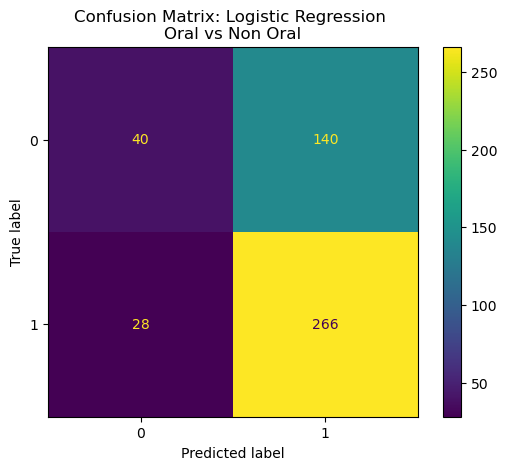

In [17]:
disp.plot()
plt.title(f"Confusion Matrix: Logistic Regression \nOral vs Non Oral")

## AUC/ROC

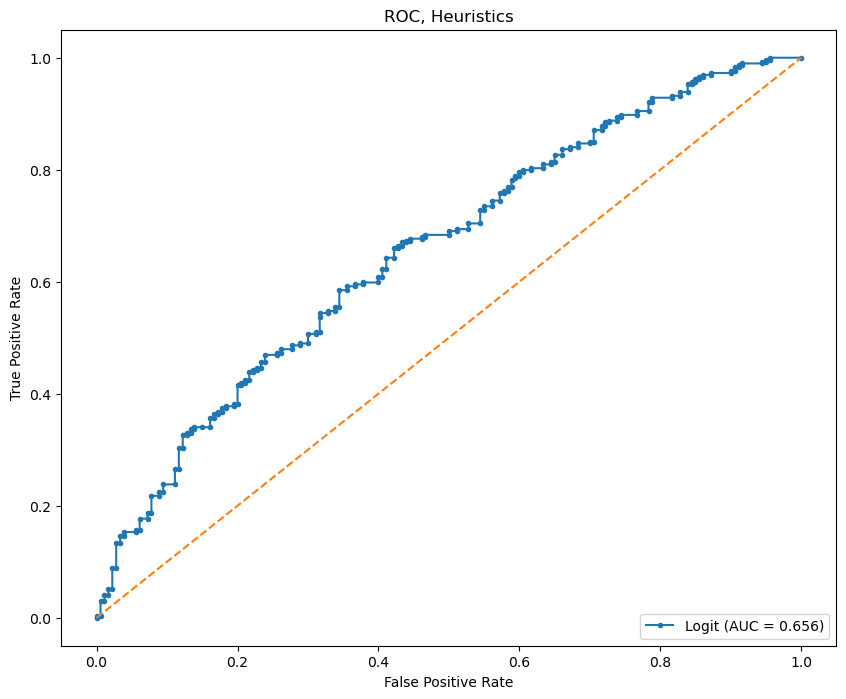

In [18]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name="Logit",
    title=f"ROC, Heuristics",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/logit_heuristics_total_testset.png"
)

## Feature Importance

In [19]:
print(logistic.coef_, logistic.intercept_)

[[-0.00144206 -0.65607011  0.47629097  0.10953141 -0.36855531  0.10034412
   0.12454344 -0.01537451  0.4012668  -0.33119246  0.09538049  0.03664116
  -0.06088174  0.09004032 -0.14332277  0.05970466  0.59364085]] [0.52328526]


## Results

In [20]:
balanced_acc_test_lr = balanced_accuracy_score(y_test, y_predict_lr_label)
mcc_test_lr = matthews_corrcoef(y_test, y_predict_lr_label)
mcc_train_lr = matthews_corrcoef(y_train, logistic.predict(x_train_scaled))

print(f"Balanced acc test set: {balanced_acc_test_lr}\
      MCC train set for logit: {mcc_train_lr}, MCC test set for logit: {mcc_test_lr}")

Balanced acc test set: 0.5634920634920635      MCC train set for logit: 0.21305334166176473, MCC test set for logit: 0.1758093151407343


In [21]:
final_results.loc[len(final_results.index)] =[
    'Logistic Regression',
    gs_results_lr['best_score'][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr,
    balanced_acc_test_lr,
    mcc_train_lr,
    mcc_test_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.628004,0.342013,0.35443,0.581734,0.656226,0.563492,0.213053,0.175809


# Decision Tree

In [22]:
dt_model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth':[2,4,8,12],
            'ccp_alpha':[0,0.000001,0.00001,0.0001, 0.0003, 0.001, 0.01]
        }
    }
}

In [23]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train_scaled, y_train, dt_model_params)

Starting Grid Search for Decision Tree: 22:45
Finished Grid Search for Decision Tree: 22:45
Tempo de execução:  0.1 minutos


In [24]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.601195,"{'ccp_alpha': 1e-06, 'criterion': 'gini', 'max..."


## Fitting tree

In [25]:
decision_tree_params = gs_result_dt.iloc[0,2]
print(decision_tree_params)
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train_scaled, y_train)

{'ccp_alpha': 1e-06, 'criterion': 'gini', 'max_depth': 4}


## Training Error and AUC

In [26]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.3061
Training AUC: 0.6132


## Test Prediction

In [27]:
y_predict_dt_label = decision_tree.predict(x_test_scaled)
y_predict_dt_prob = decision_tree.predict_proba(x_test_scaled)[:,1]

## Test errors

In [28]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_dt_label
)

Misclassification rate: 0.3418


Text(0.5, 1.0, 'CM Decision Tree Test Set\nOral vs Non Oral Drugs')

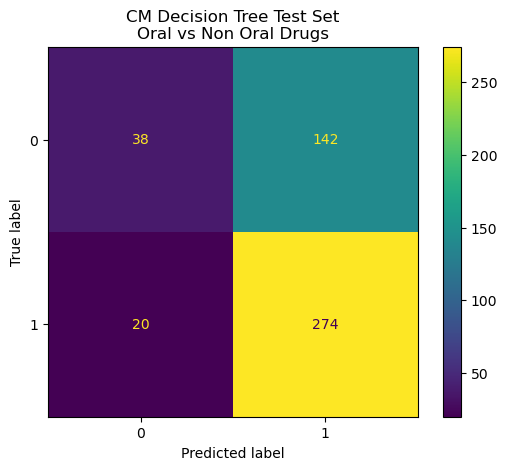

In [29]:
disp.plot()
plt.title(f"CM Decision Tree Test Set\nOral vs Non Oral Drugs")

## ROC Test

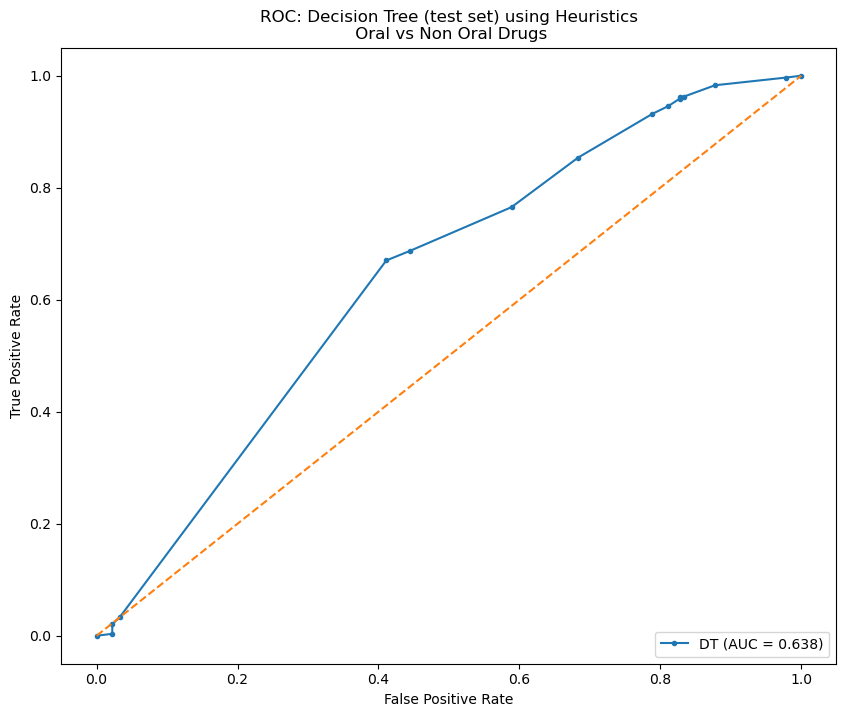

In [30]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name='DT',
    title=f"ROC: Decision Tree (test set) using Heuristics\n Oral vs Non Oral Drugs",
    save_path=f'/home/gustavo/github/mestrado/reworks/imgs/dt_heuristics_testset.png'
)

## Feature Importance

Text(0.5, 1.0, 'Featuer importance: Decision Trees \n Oral vs Non oral Drugs')

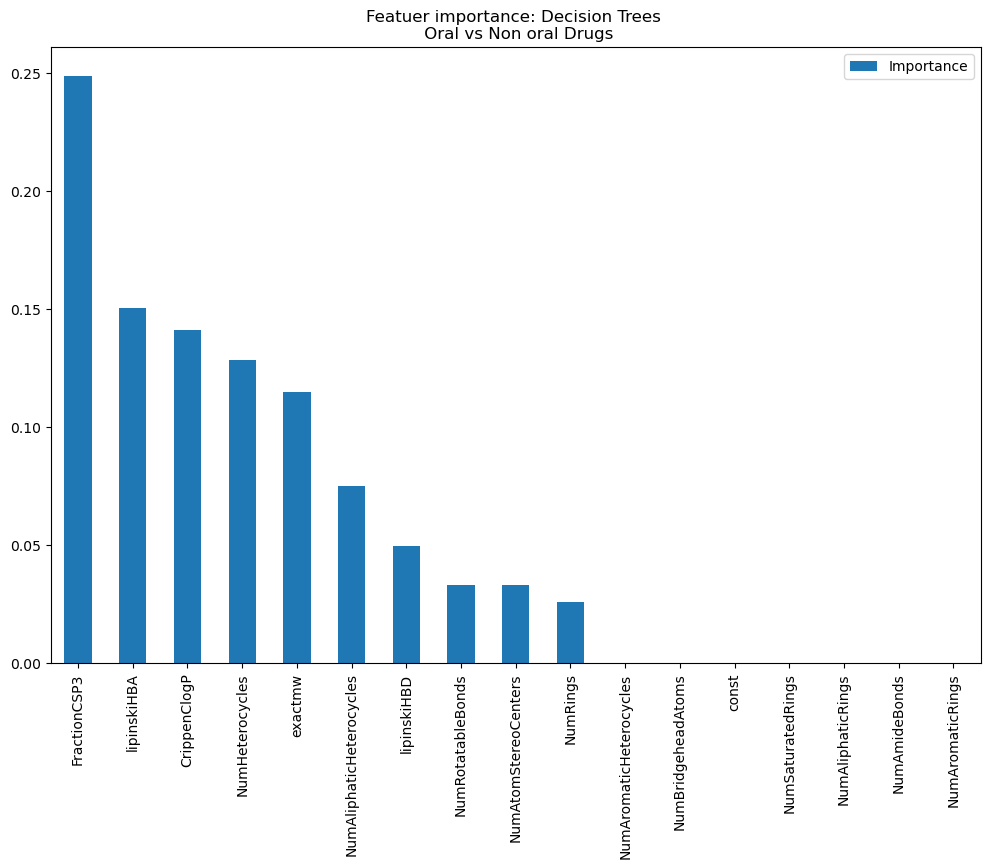

In [31]:
# print the feature importances
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(
    decision_tree.feature_importances_,
    index=x_train_scaled.columns,
    columns=['Importance']
)
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30, :].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Featuer importance: Decision Trees \n Oral vs Non oral Drugs")

In [32]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by='Importance',
                                                                                      ascending=False)
important_features_dt[0:30]

,Importance
FractionCSP3,0.248466
lipinskiHBA,0.150555
CrippenClogP,0.140924
NumHeterocycles,0.128403
exactmw,0.114782
NumAliphaticHeterocycles,0.075125
lipinskiHBD,0.049650
NumRotatableBonds,0.033119
NumAtomStereoCenters,0.032934
NumRings,0.026041


## Results

In [33]:
balanced_acc_test_dt = balanced_accuracy_score(y_test, y_predict_dt_label)
mcc_train_dt = matthews_corrcoef(y_train, decision_tree.predict(x_train_scaled))
mcc_test_dt = matthews_corrcoef(y_test, y_predict_dt_label)

print(f"Balanced ACC test set: {balanced_acc_test_dt}\
      MCC train {mcc_train_dt} e MCC test {mcc_test_dt}")

final_results.loc[len(final_results.index)] = [
    "Decision Tree",
    gs_result_dt['best_score'][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt,
    balanced_acc_test_dt,
    mcc_train_dt,
    mcc_test_dt

]

final_results

Balanced ACC test set: 0.5715419501133787      MCC train 0.31630873950091093 e MCC test 0.21190442484003433


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.628004,0.342013,0.354430,0.581734,0.656226,0.563492,0.213053,0.175809
1,Decision Tree,0.601195,0.306122,0.341772,0.613155,0.638029,0.571542,0.316309,0.211904


# Random Forest and Bagging

Training Misclassification Rate: 0.1372
Training AUC: 0.8235
Misclassification rate: 0.3291


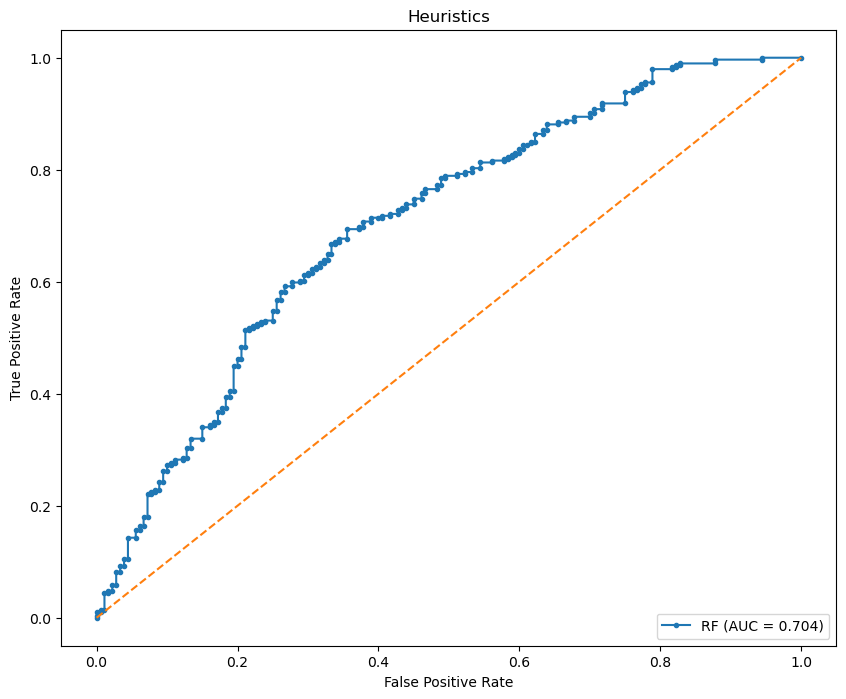

In [34]:
# Testing
rf_model_params_test = {'max_depth':10, 'ccp_alpha':0.0002, 'min_samples_split':4}
rf_test = RandomForestClassifier(**rf_model_params_test).fit(x_train_scaled,y_train)

#Make predcitions
y_predict_rf_label_test = rf_test.predict(x_test_scaled)
y_predict_rf_prob_test = rf_test.predict_proba(x_test_scaled)[:,1]

mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=rf_test,
    x=x_train_scaled,
    y_true=y_train
)

#test errors
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test,
    y_pred=y_predict_rf_label_test
)

auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob_test,
    model_name='RF',
    title=f'Heuristics',
    save_path='/home/gustavo/github/mestrado/reworks/imgs/rf_test.png'

)

In [35]:
# Hyperparameter finetuning
rf_model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'max_depth': [5,6,8,9,10],
            'max_features':['sqrt',x_train.shape[0]],
            'ccp_alpha': [0.0003, 0.0009, 0.0011],
            'min_samples_split':[4,6]
        }
    }
}

In [36]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train_scaled, y_train, rf_model_params)

Starting Grid Search for Random Forest: 22:45
Finished Grid Search for Random Forest: 22:49
Tempo de execução:  3.5 minutos


In [37]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.691892,"{'ccp_alpha': 0.0011, 'max_depth': 9, 'max_fea..."


## Fitting Model

In [38]:
random_forest_params = gs_result_rf.iloc[0,2]
print(random_forest_params)

random_forest = RandomForestClassifier(**random_forest_params).fit(x_train_scaled, y_train)

{'ccp_alpha': 0.0011, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 6}


## Making test predictions

In [39]:
y_predict_rf_label = random_forest.predict(x_test_scaled)
y_predict_rf_prob = random_forest.predict_proba(x_test_scaled)[:,1]

## Get Training Error and Training AUC

In [40]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.1865
Training AUC: 0.7595


## Test error

In [41]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_rf_label
)

Misclassification rate: 0.3080


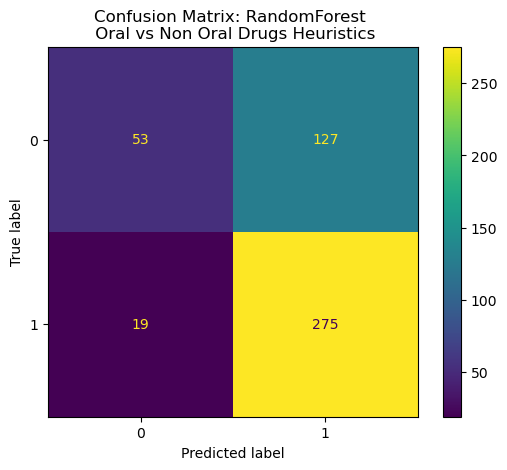

In [42]:
disp.plot()
plt.title(f"Confusion Matrix: RandomForest \n Oral vs Non Oral Drugs Heuristics")
plt.show()

## ROC/AUC

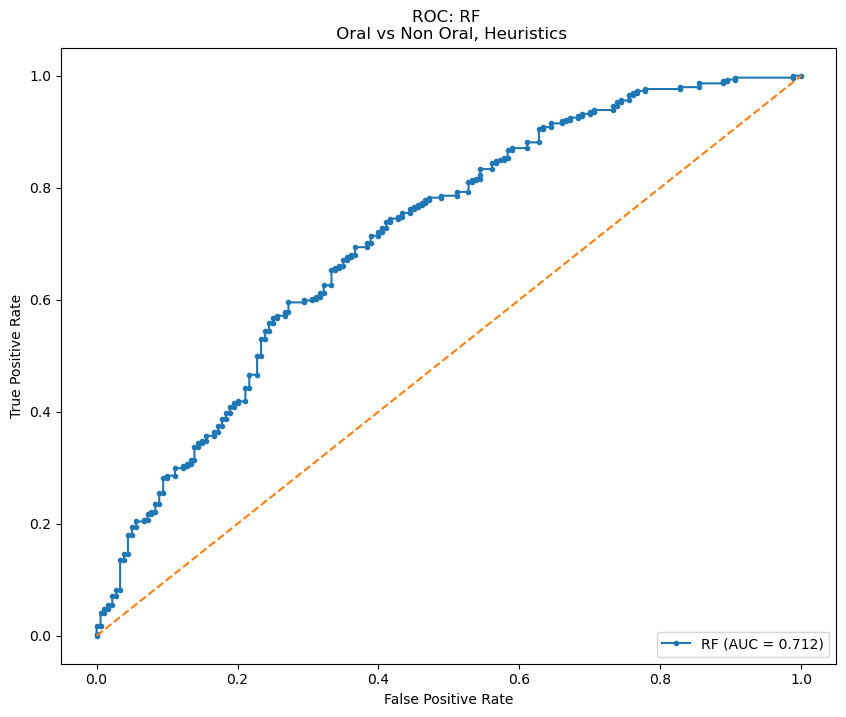

In [43]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name='RF',
    title=f"ROC: RF \n Oral vs Non Oral, Heuristics",
    save_path=f'/home/gustavo/github/mestrado/reworks/imgs/roc_auc_heuristics_rf.png'
)

## Feature Importance

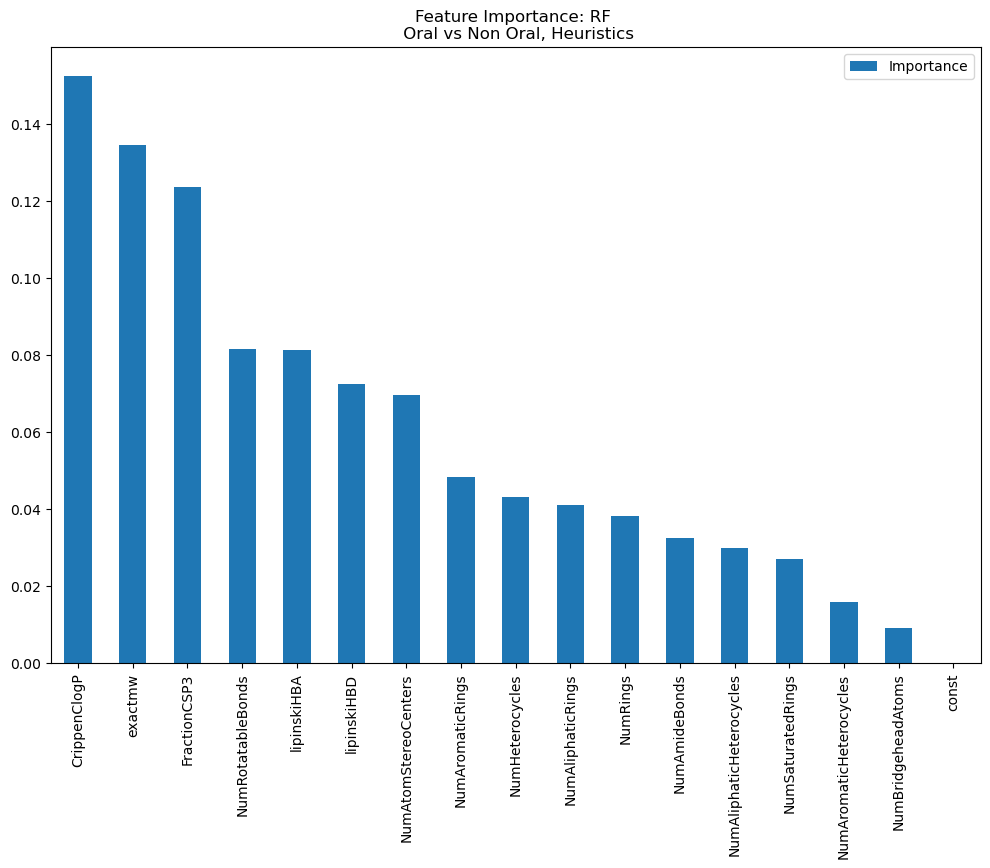

In [44]:
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(random_forest.feature_importances_,
                                index=x_train_scaled.columns,
                                columns=['Importance'])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance: RF \n Oral vs Non Oral, Heuristics")
fig.savefig(f"/home/gustavo/github/mestrado/reworks/imgs/feature_importance_rf_heuristics.png")

In [45]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by='Importance', ascending=False)
important_features_rf[0:30]

,Importance
CrippenClogP,0.152250
exactmw,0.134455
FractionCSP3,0.123588
NumRotatableBonds,0.081652
lipinskiHBA,0.081167
lipinskiHBD,0.072316
NumAtomStereoCenters,0.069569
NumAromaticRings,0.048320
NumHeterocycles,0.043245
NumAliphaticRings,0.041049


## Saving results

In [46]:
balanced_acc_test_rf = balanced_accuracy_score(y_test, y_predict_rf_label)
mcc_train_rf = matthews_corrcoef(y_train, random_forest.predict(x_train_scaled))
mcc_test_rf = matthews_corrcoef(y_test, y_predict_rf_label)

print(f"Balanced ACC test set random forest: {balanced_acc_test_rf}\
      MCC train set: {mcc_train_rf}, MCC test set {mcc_test_rf}")

final_results.loc[len(final_results.index)] = [
    'Random Forest',
    gs_result_rf['best_score'][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf,
    balanced_acc_test_rf,
    mcc_train_rf,
    mcc_test_rf
]

final_results

Balanced ACC test set random forest: 0.6149092970521542      MCC train set: 0.6132006130547574, MCC test set 0.3107533409966747


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.628004,0.342013,0.354430,0.581734,0.656226,0.563492,0.213053,0.175809
1,Decision Tree,0.601195,0.306122,0.341772,0.613155,0.638029,0.571542,0.316309,0.211904
2,Random Forest,0.691892,0.186488,0.308017,0.759527,0.712443,0.614909,0.613201,0.310753


# Gradient Boosting

Training Misclassification Rate: 0.2224
Training AUC: 0.7190
Misclassification rate: 0.3080


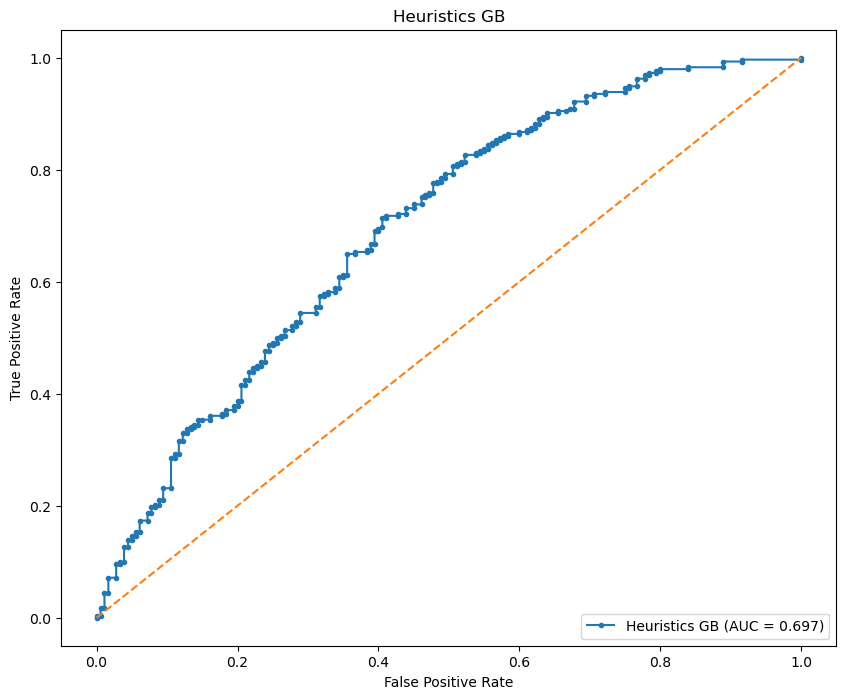

In [47]:
# Testing to see which paremeters are good
gradient_boost_test_params ={'max_depth':5,
                             'min_samples_split':28,
                             'max_features':'sqrt',
                             'learning_rate':0.04,
                             'subsample':0.7}

boost_test = GradientBoostingClassifier(**gradient_boost_test_params).fit(x_train_scaled, y_train)

# make prediction
y_predict_boost_label_test = boost_test.predict(x_test_scaled)
y_predict_boost_prob_test = boost_test.predict_proba(x_test_scaled)[:,1]

# mis rate of train and auc of train
mis_rate_boost_train, auc_boost_train = get_error_and_auc(
    model=boost_test,
    x=x_train_scaled,
    y_true=y_train
)

# Test error
mis_rate_boost_test, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_boost_label_test
)

auc_boost = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boost_prob_test,
    model_name='Heuristics GB',
    title=f'Heuristics GB',
    save_path='/home/gustavo/github/mestrado/reworks/imgs/boost_test_heuristics.png'
)

In [48]:
boosting_model_params = {
    'Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate':[0.03,0.04],
            'max_depth': [5,8],
            'min_samples_split':[16,18],
            'subsample':[0.6]
        }
    }
}

In [49]:
gs_result_boost, gs_result_boost_full = best_params_grid(x_train_scaled, y_train, boosting_model_params)

Starting Grid Search for Boosting: 22:49
Finished Grid Search for Boosting: 22:49
Tempo de execução:  0.5 minutos


## Fitting the model

In [50]:
boosting_params = gs_result_boost.iloc[0,2]
print(boosting_params)

boosting = GradientBoostingClassifier(**boosting_params).fit(x_train_scaled, y_train)

{'learning_rate': 0.03, 'max_depth': 5, 'min_samples_split': 16, 'subsample': 0.6}


## Get training error and AUC

In [51]:
mis_rate_boost_train, auc_boost_train = get_error_and_auc(
    model=boosting,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.2013
Training AUC: 0.7447


## Make predictions

In [52]:
y_predict_boost_label = boosting.predict(x_test_scaled)
y_predict_boost_prob = boosting.predict_proba(x_test_scaled)[:,1]

## Test error

In [53]:
mis_rate_boost, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_boost_label
)

Misclassification rate: 0.3186


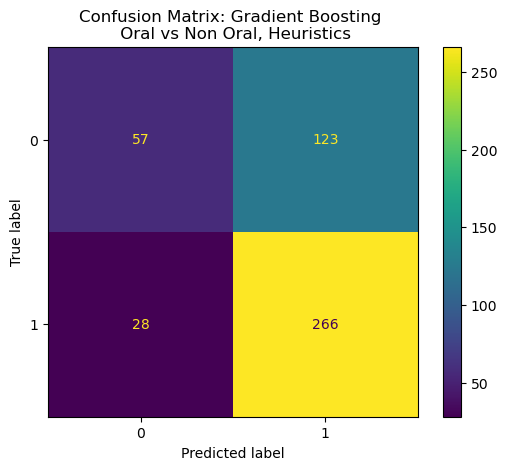

In [54]:
disp.plot()
plt.title(f"Confusion Matrix: Gradient Boosting \n Oral vs Non Oral, Heuristics")
plt.show()

## ROC/AUC

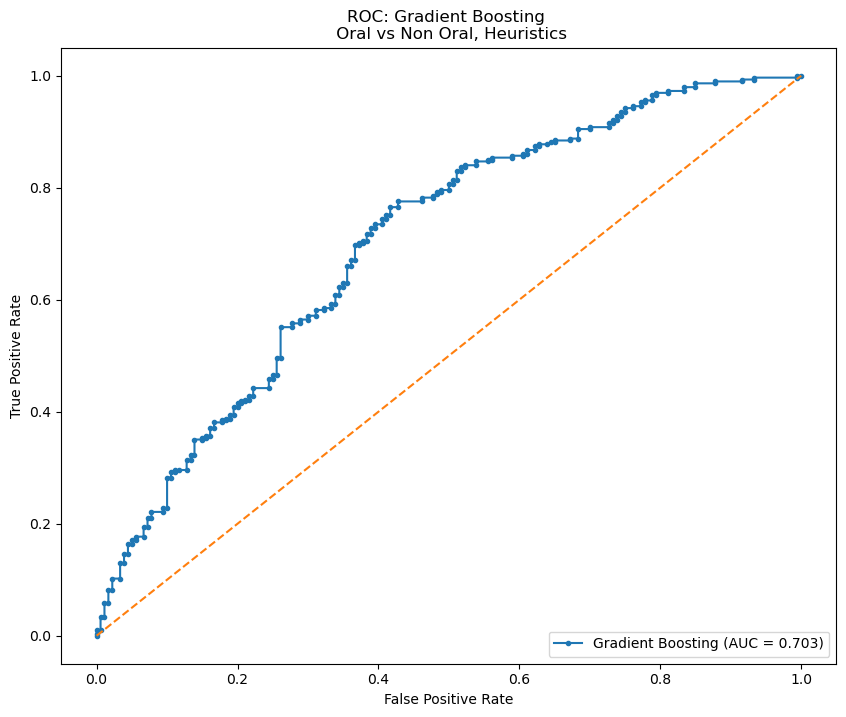

In [55]:
auc_boost = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boost_prob,
    model_name='Gradient Boosting',
    title=f"ROC: Gradient Boosting \n Oral vs Non Oral, Heuristics",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/roc_auc_heuristics_gb.png"
)

## Feature Importance

Text(0.5, 1.0, 'Feature Importance: Gradient Boosting \n Oral vs Non Oral, Heuristic')

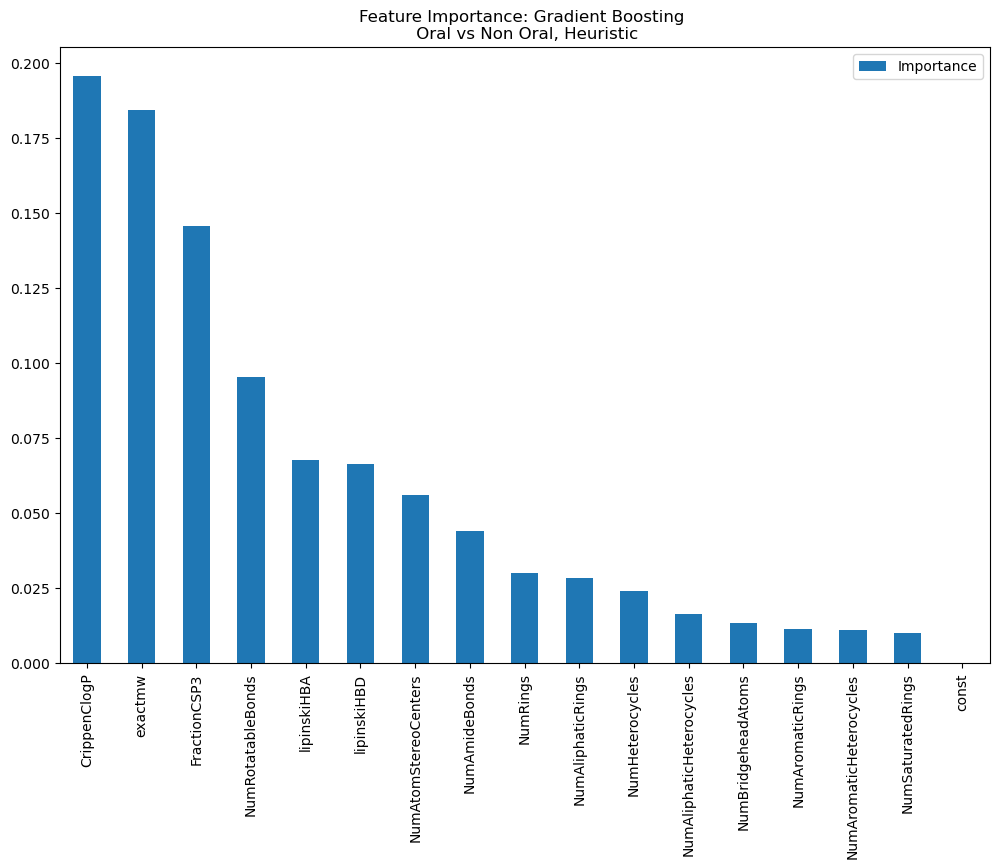

In [56]:
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(boosting.feature_importances_,
                                index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance: Gradient Boosting \n Oral vs Non Oral, Heuristic")

In [57]:
important_features_boost = feat_importances[feat_importances.Importance >0].sort_values(by='Importance', ascending=False)
important_features_boost[0:30]

,Importance
CrippenClogP,0.195583
exactmw,0.184475
FractionCSP3,0.145738
NumRotatableBonds,0.095433
lipinskiHBA,0.067866
lipinskiHBD,0.066402
NumAtomStereoCenters,0.055953
NumAmideBonds,0.044104
NumRings,0.029923
NumAliphaticRings,0.028412


## Saving Results


In [58]:
balanced_acc_test_boost = balanced_accuracy_score(y_test, y_predict_boost_label)
mcc_train_boost = matthews_corrcoef(y_train, boosting.predict(x_train_scaled))
mcc_test_boost = matthews_corrcoef(y_test, y_predict_boost_label)

print(f"Balanced ACC test set {balanced_acc_test_boost}, \
      MCC test set: {mcc_test_boost}, MCC train set: {mcc_train_boost}")


final_results.loc[len(final_results.index)] = [
    'Gradient Boosting',
    gs_result_boost['best_score'][0],
    mis_rate_boost_train,
    mis_rate_boost,
    auc_boost_train,
    auc_boost,
    balanced_acc_test_boost,
    mcc_train_boost,
    mcc_test_boost
]

final_results

Balanced ACC test set 0.6107142857142858,       MCC test set: 0.2801298007665085, MCC train set: 0.5748477238005428


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.628004,0.342013,0.354430,0.581734,0.656226,0.563492,0.213053,0.175809
1,Decision Tree,0.601195,0.306122,0.341772,0.613155,0.638029,0.571542,0.316309,0.211904
2,Random Forest,0.691892,0.186488,0.308017,0.759527,0.712443,0.614909,0.613201,0.310753
3,Gradient Boosting,0.687193,0.201267,0.318565,0.744731,0.703042,0.610714,0.574848,0.280130


# SVM

Training Misclassification Rate: 0.2695
Training AUC: 0.6586
Misclassification rate: 0.3080


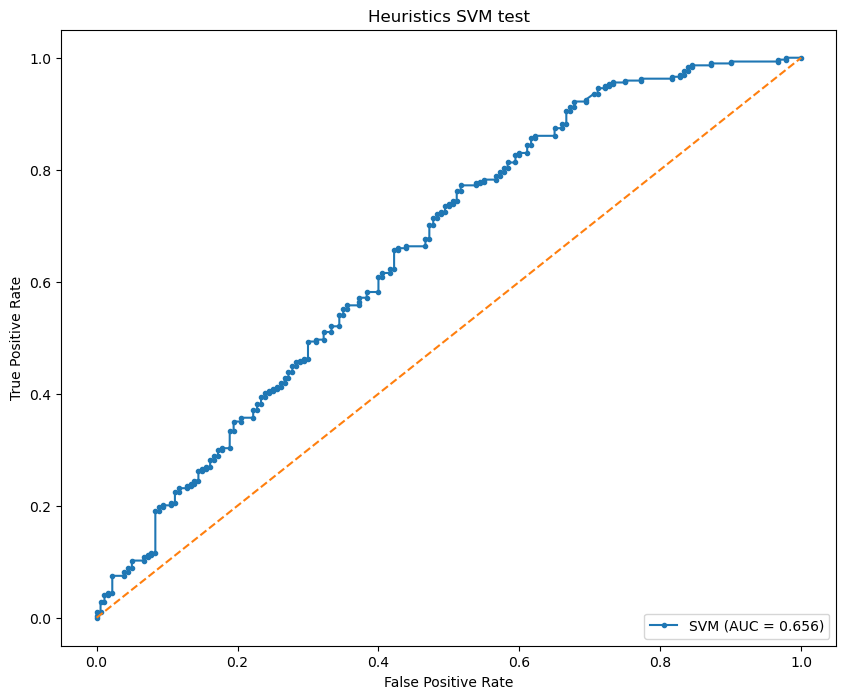

In [59]:
# Testing

svm_test_params = {
    'C':2,
    'kernel':'rbf',
    'gamma':'auto'
}

svm_test = SVC(**svm_test_params, probability=True).fit(x_train_scaled, y_train)

# make predictions
y_predict_svm_label_test = svm_test.predict(x_test_scaled)
y_predict_svm_prob_test = svm_test.predict_proba(x_test_scaled)[:,1]


mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm_test,
    x=x_train_scaled,
    y_true=y_train,
)

# Test error
mis_rate_svm_test, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_svm_label_test
)

auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob_test,
    model_name='SVM',
    title=f"Heuristics SVM test",
    save_path='/home/gustavo/github/mestrado/reworks/imgs/svm_test.png'
)

## Hyperparameter Fine Tuning

In [60]:
svm_model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.01, 0.1, 0.2, 1, 2, 4],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', 0.0001, 0.001]
        }
    }
}

In [61]:
gs_results_svm, gs_results_svm_full = best_params_grid(x_train_scaled, y_train, svm_model_params)

Starting Grid Search for SVM: 22:49
Finished Grid Search for SVM: 22:50
Tempo de execução:  0.7 minutos


## Fitting the Model

In [62]:
svm_params = gs_results_svm.iloc[0,2]
print(svm_params)
svm = SVC(**svm_params, probability=True).fit(x_train_scaled, y_train)

{'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}


## Get Training Error and AUC

In [63]:
miss_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.2695
Training AUC: 0.6586


## Make prediction

In [64]:
y_predict_svm_label = svm.predict(x_test_scaled)
y_predict_svm_prob = svm.predict_proba(x_test_scaled)[:,1]

## Test Error

Misclassification rate: 0.3080


Text(0.5, 1.0, 'Confusion Matrix SVM \n Oral vs Non Oral, Heuristics')

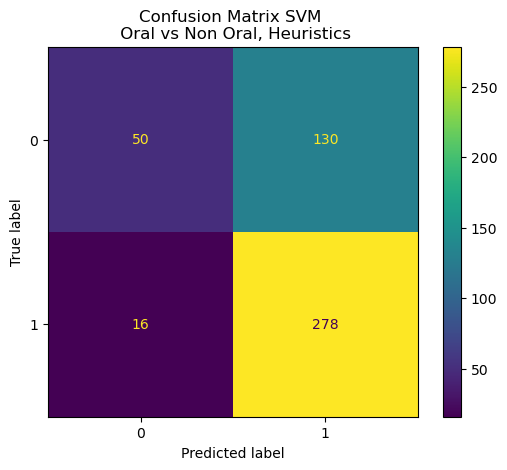

In [65]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_svm_label
)

disp.plot()
plt.title(f"Confusion Matrix SVM \n Oral vs Non Oral, Heuristics")

## ROC

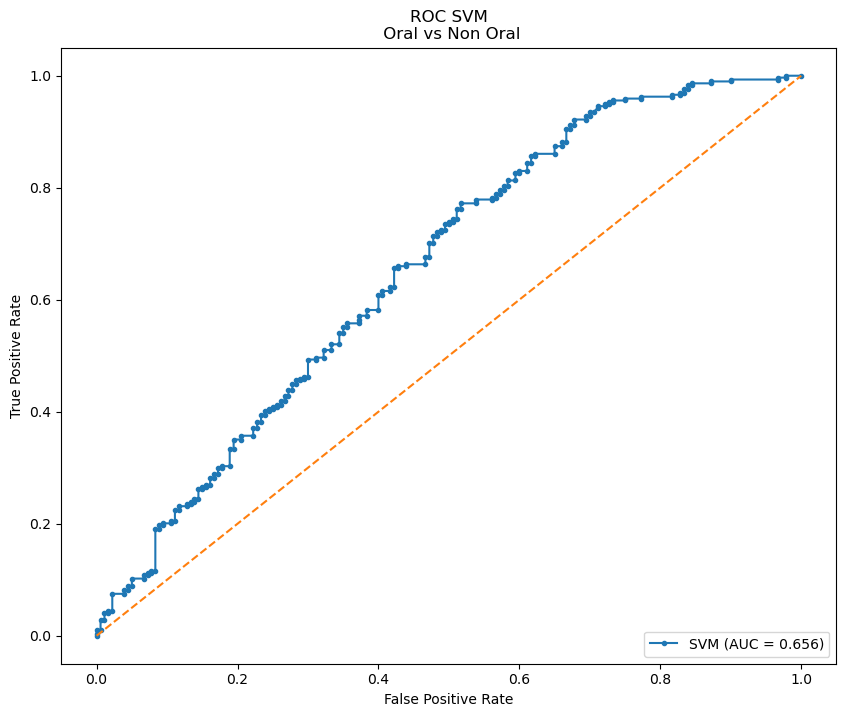

In [66]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name='SVM',
    title=f"ROC SVM\n Oral vs Non Oral",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/roc_auc_heursitisc_svm.png"
)

## Saving Results

In [67]:
balanced_acc_test_svm = balanced_accuracy_score(y_test, y_predict_svm_label)
mcc_train_svm = matthews_corrcoef(y_train, svm.predict(x_train_scaled))
mcc_test_svm = matthews_corrcoef(y_test, y_predict_svm_label)

print(f"Balanced ACC test {balanced_acc_test_svm}\
      MCC train: {mcc_train_svm} and MCC test: {mcc_test_svm}")

Balanced ACC test 0.6116780045351474      MCC train: 0.4140612707628376 and MCC test: 0.31311617963513955


In [68]:
final_results.loc[len(final_results.index)] = [
    'SVM',
    gs_results_svm['best_score'][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm,
    balanced_acc_test_svm,
    mcc_train_svm,
    mcc_test_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_tets
0,Logistic Regression,0.628004,0.342013,0.354430,0.581734,0.656226,0.563492,0.213053,0.175809
1,Decision Tree,0.601195,0.306122,0.341772,0.613155,0.638029,0.571542,0.316309,0.211904
2,Random Forest,0.691892,0.186488,0.308017,0.759527,0.712443,0.614909,0.613201,0.310753
3,Gradient Boosting,0.687193,0.201267,0.318565,0.744731,0.703042,0.610714,0.574848,0.280130
4,SVM,0.663511,0.269529,0.308017,0.658577,0.656330,0.611678,0.414061,0.313116
